In [1]:
import numpy as np
from numpy import float32
import warnings
import os
import sys
import glob
import tensorflow as tf
import cv2
from sklearn import utils
from sklearn import preprocessing
import matplotlib.pyplot as plt
import Augmentor
from pathlib import Path

import tensorflow.keras.backend as K
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras.utils import *
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

sys.path.append(os.path.join(Path.cwd(), 'utils'))

from utils.im_utils import *
from utils.resnet_model import *
from utils.simple_conv_model import *

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
FLARE_CLASS = 'B'

TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_data/train'
VAL_DATA_DIR = f'./data/{FLARE_CLASS}_data/val'
TEST_DATA_DIR = f'./data/{FLARE_CLASS}_data/test'

AUG_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/train'
AUG_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/val'
AUG_TEST_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/test'

RESNET_CHECKPOINTS_DIR = './checkpoints/resnet_checkpoints'

In [4]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [5]:
def augment_train_data():
    delete_files(f'{AUG_TRAIN_DATA_DIR}/positive')
    delete_files(f'{AUG_TRAIN_DATA_DIR}/negative')
    
    for subdir, dirs, files in os.walk(TRAIN_DATA_DIR):
        for file in files:
            filepath = os.path.join(subdir, file)
            img = np.load(filepath)
            # rotated_imgs = [rotate_img(img, 90), rotate_img(img, 180), rotate_img(img, 270)]
            # for idx, rot_img in enumerate(rotated_imgs):
            #     rotated_img_save = os.path.join(subdir, f'{file}_{idx}_rot')
            #     np.save(rotated_img_save, rot_img)

            fliplr_img = np.fliplr(img)
            flipud_img = np.flipud(img)
            rot90_img = np.rot90(img)
            rot180_img = np.rot90(img, 2)
            rot270_img = np.rot90(img, 3)
            
            folder = subdir.rsplit('/', 1)[1]
            cut_filename = file.rsplit('.', 1)[0]

            original_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', cut_filename)
            fliplr_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', f'{cut_filename}_fliplr')
            flipud_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', f'{cut_filename}_flipud')
            rot90_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', f'{cut_filename}_rot90')
            rot180_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', f'{cut_filename}_rot180')
            rot270_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', f'{cut_filename}_rot270')

            np.save(original_img_save, img)
            np.save(fliplr_img_save, fliplr_img)
            np.save(flipud_img_save, flipud_img)
            np.save(rot90_img_save, rot90_img)
            np.save(rot180_img_save, rot180_img)
            np.save(rot270_img_save, rot270_img)

            # translated_img = translate(img)
            # translated_img_save = os.path.join(subdir, f'{file}_trans')
            # np.save(translated_img_save, translated_img)

In [6]:
# augment_train_data()

In [7]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, files_paths,
                 batch_size,
                 input_size=(128, 128, 1),
                 shuffle=True):
        
        self.files_paths = files_paths.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.files_paths)
        self.n_category = 2
        # self.n_name = df[y_col['name']].nunique()
        # self.n_type = df[y_col['type']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.files_paths)
    
    def __getitem__(self, index):
        batches = self.files_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __get_input(self, path):
        # image = preprocessing.normalize(np.load(path))
        image = np.load(path)
        # image = NormalizeData(image)
        # image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA)
        # image = preprocessing.normalize(image)
        return image

    def __get_output(self, path, num_classes=2):
        label = None
        folder = path.rsplit('/')[-2]
        if folder == 'positive':
            label = 1
        elif folder == 'negative':
            label = 0
        
        return label
        # return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        # path_batch = batches[self.X_col['path']]
        # category_batch = batches[self.y_col['type']]

        X_batch = np.asarray([self.__get_input(x) for x in batches])
        y_batch = np.asarray([self.__get_output(y, self.n_category) for y in batches])

        return X_batch, y_batch

In [8]:
train_files = []
for subdir, dirs, files in os.walk(AUG_TRAIN_DATA_DIR):
     for f in files:
        train_files.append(os.path.join(subdir, f))
train_files = np.array(train_files)

val_files = []
for subdir, dirs, files in os.walk(AUG_VAL_DATA_DIR):
     for f in files:
        val_files.append(os.path.join(subdir, f))
val_files = np.array(val_files)

test_files = []
for subdir, dirs, files in os.walk(AUG_TEST_DATA_DIR):
     for f in files:
        test_files.append(os.path.join(subdir, f))
test_files = np.array(test_files)

In [9]:
def get_test_conv_model():
    inp = Input(shape=(64, 64, 1))
    x = Conv2D(filters=48, kernel_size=4)(inp)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Conv2D(filters=24, kernel_size=3)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Conv2D(filters=12, kernel_size=3)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, x)
    adam_fine = Adam(learning_rate=1, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    model.compile(
        loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"]
    )
    
    return model

In [10]:
batch_size = 512
epochs=30
traingen = CustomDataGen(train_files, batch_size)
valgen = CustomDataGen(val_files, batch_size)

In [11]:
model = get_test_conv_model()
# model.summary()
history = model.fit(traingen, validation_data = valgen, epochs=epochs)

2022-08-01 22:05:07.910283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 22:05:08.500449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6656 MB memory:  -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:82:00.0, compute capability: 7.5


Epoch 1/30


2022-08-01 22:05:10.523672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-01 22:05:11.086724: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-01 22:05:11.091129: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


28/28 [==============================] - 11s 283ms/step - loss: 3.0230 - accuracy: 0.5337
Epoch 2/30
28/28 [==============================] - 8s 287ms/step - loss: 0.6942 - accuracy: 0.6720
Epoch 3/30
28/28 [==============================] - 8s 292ms/step - loss: 0.6130 - accuracy: 0.7179
Epoch 4/30
28/28 [==============================] - 8s 287ms/step - loss: 0.5883 - accuracy: 0.7292
Epoch 5/30
28/28 [==============================] - 8s 288ms/step - loss: 0.5759 - accuracy: 0.7355
Epoch 6/30
28/28 [==============================] - 8s 289ms/step - loss: 0.5682 - accuracy: 0.7383
Epoch 7/30
28/28 [==============================] - 8s 279ms/step - loss: 0.5625 - accuracy: 0.7418
Epoch 8/30
28/28 [==============================] - 8s 277ms/step - loss: 0.5579 - accuracy: 0.7438
Epoch 9/30
28/28 [==============================] - 8s 285ms/step - loss: 0.5530 - accuracy: 0.7458
Epoch 10/30
28/28 [==============================] - 8s 295ms/step - loss: 0.5485 - accuracy: 0.7470
Epoch 11/

In [12]:
predictions = model.predict(valgen[0][0])
true_vals = valgen[0][1]

correct = 0
for idx, pred in enumerate(predictions):
    pred_round = 0
    if pred >= 0.5:
        pred_round = 1
    if pred_round == true_vals[idx]:
        correct += 1

print(f'accuracy: {correct/(len(true_vals))}')

10/10 [==============================] - 0s 6ms/step
accuracy: 0.767515923566879


In [13]:
model.save_weights(f'{RESNET_CHECKPOINTS_DIR}/simple_conv')

In [18]:
epochs = 30
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
adam_fine = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [19]:
model = CustomResNet50(include_top=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(traingen, validation_data = valgen, epochs=epochs)

channels_last


2022-07-28 04:14:39.334111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 04:14:40.006827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6656 MB memory:  -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:82:00.0, compute capability: 7.5


Epoch 1/30


2022-07-28 04:14:46.675046: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-28 04:14:47.296835: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 04:14:47.302075: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


230/230 [==============================] - 64s 241ms/step - loss: 0.8622 - accuracy: 0.5050 - val_loss: 0.7033 - val_accuracy: 0.4766
Epoch 2/30
230/230 [==============================] - 55s 237ms/step - loss: 0.6572 - accuracy: 0.6761 - val_loss: 0.5637 - val_accuracy: 0.7500
Epoch 3/30
230/230 [==============================] - 55s 238ms/step - loss: 0.6280 - accuracy: 0.6996 - val_loss: 0.5443 - val_accuracy: 0.7773
Epoch 4/30
230/230 [==============================] - 55s 238ms/step - loss: 0.6207 - accuracy: 0.7023 - val_loss: 0.7138 - val_accuracy: 0.7656
Epoch 5/30
230/230 [==============================] - 55s 237ms/step - loss: 0.6171 - accuracy: 0.7068 - val_loss: 0.5424 - val_accuracy: 0.7773
Epoch 6/30
230/230 [==============================] - 55s 238ms/step - loss: 0.6098 - accuracy: 0.7107 - val_loss: 0.5187 - val_accuracy: 0.7656
Epoch 7/30
230/230 [==============================] - 55s 237ms/step - loss: 0.6013 - accuracy: 0.7124 - val_loss: 0.7074 - val_accuracy: 0.7

In [21]:
model.save_weights(f'{RESNET_CHECKPOINTS_DIR}/sgd_newdata_B_class_1e-3_checkpoint')

In [35]:
t = np.load('./data/B_data/train/positive/AIA20160107_0354_0094_0.npy')
t = cv2.resize(t, (128, 128), interpolation = cv2.INTER_AREA)
t = np.array([t.reshape(128, 128, 1)]) 

In [36]:
model.predict(t)

1/1 [==============================] - 0s 39ms/step


array([[0.9931339]], dtype=float32)

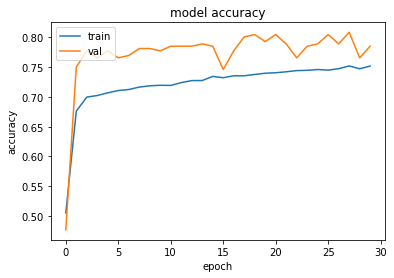

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

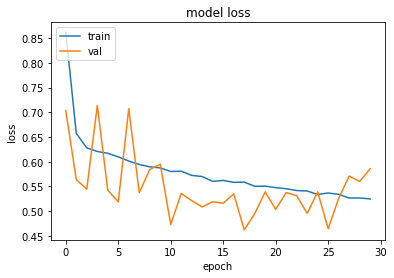

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()